# Cut-it

En este proyecto la idea es desarrollar un algorithmo de segmentación de imagenes a color, utilizando el Mean  Sift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## Algoritmo de mean-shift

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## Algoritmo basado en grafos.

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu eexplica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree # fast K-neighbors queries
from sklearn.cluster import KMeans
# for display in cells
from IPython.display import clear_output
from sys import stdout 

%matplotlib inline

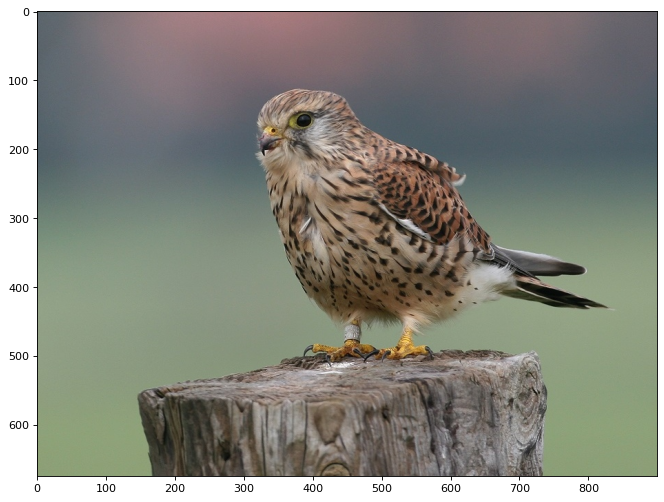

In [3]:
bird = cv2.cvtColor(cv2.imread('imgs/bird.jpg'), cv2.COLOR_BGR2RGB)

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(bird)

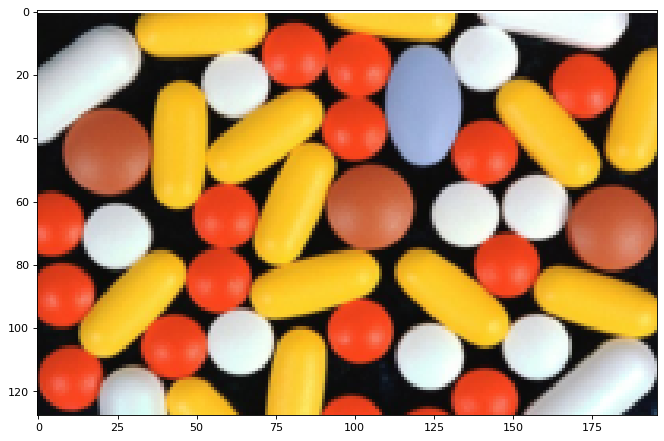

In [4]:
pills = cv2.cvtColor(cv2.imread('imgs/pills.png'), cv2.COLOR_BGR2RGB)

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(pills)

In [5]:
def mean_shift(pts, radius , shift_stop_dist = 1e-3, mix_convergence=1e-3,  geometric_mean=True, max_iters = int(10e5), display_error=True):
    # make points positive 
    if geometric_mean:
        offset = pts.min(axis=0)
        pts = (pts - offset) + 1
    
    def mass_center(ipts, geometric=True):
        if geometric:
            return np.exp(np.mean(np.log(ipts), axis=0))
        else:
            return np.mean(ipts, axis=0)

    tree = BallTree(pts)
    prev_mean = None
    pts_mean = pts.copy()

    iters = 0
    donemask = np.zeros(len(pts), dtype=bool)

    while True:
        # Only update and calculate those who are NOT done.
        prev_mean = pts_mean.copy()
        idx = tree.query_radius(pts_mean[~donemask], r=radius)
        
        pts_mean[~donemask] = np.array([mass_center(pts[i], geometric=geometric_mean) for i in idx])

        # Calculate average shift
        if display_error:
            shifted = np.mean(np.linalg.norm(prev_mean[~donemask] - pts_mean[~donemask], axis=1))
        

        donemask[~donemask] = np.linalg.norm(prev_mean[~donemask] - pts_mean[~donemask], axis=1) < shift_stop_dist

        if display_error:
            clear_output()
            stdout.write(f"Average shift distance: {shifted}")
            stdout.flush()

        if np.all(donemask):
            break

        iters += 1
        if iters >= max_iters:
            break
        

    tagged = {}
    temp_tree = BallTree(pts_mean)
    centroids = []
    curr_class = 0
    for i in range(len(pts_mean)): # Linear in convergence of classes, still kind of slow just due to it being raw python
        if tagged.get(i) is not None:
            continue
        res = temp_tree.query_radius(pts_mean[i].reshape(1, -1), r=mix_convergence)[0]
        centroids.append(pts_mean[i])
        tagged[i] = curr_class
        # print(res)
        for k in res:
            tagged[k] = curr_class
        curr_class += 1

    if geometric_mean:
        return np.array(centroids) + offset - 1 , [tagged[i] for i in range(len(pts_mean))]
    else:
        return np.array(centroids), [tagged[i] for i in range(len(pts_mean))]


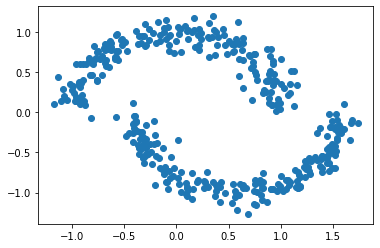

In [6]:
rng = np.random.default_rng(42)

N = 200
t = rng.random([N, 1]) * np.pi
t2 = rng.random([N, 1]) * np.pi + np.pi

pts1 = np.column_stack([np.cos(t), np.sin(t)])
pts2 = np.column_stack([np.cos(t2), np.sin(t2)])

pts2[:,0] += 0.6

# noisify.-
pts1 += rng.normal(scale=0.1,size=[N, 2])
pts2 += rng.normal(scale=0.1,size=[N, 2])


pts = np.row_stack([pts1, pts2])
plt.scatter(pts[:,0], pts[:,1])
plt.show()

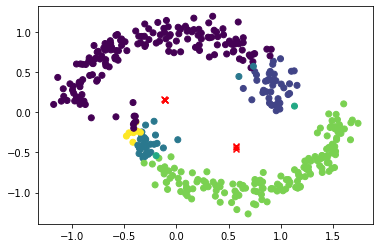

In [7]:
centroids, labels = mean_shift(pts, radius=1.3, geometric_mean=True, display_error =False)
plt.scatter(pts[:,0],pts[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red')

In [385]:
def position_extend_mat(mat, weight = 1):
    n,m, _ = np.shape(mat)
    X,Y = np.meshgrid(np.linspace(0, 1, m), np.linspace(0,1, n))
    helpmat = np.zeros((mat.shape[0], mat.shape[1], mat.shape[2] + 2))
    helpmat[:,:,:mat.shape[2]] = mat
    helpmat[:,:,-2] = X * weight
    helpmat[:,:,-1] = Y * weight
    return helpmat
    
def img2R5(input_img, normalize=True, dist_scale=1, color_scale=1):
  help_img = input_img.astype('float32')
  if input_img.max() > 1 and normalize:
    help_img[:,:,:3] = help_img / 255

  help_img = help_img*color_scale # either expand or make colors closers.
  help_img = position_extend_mat(help_img, dist_scale)
  return help_img.reshape(-1,5)

def img2R3(input_img, normalize=True, only_color=True, dist_scale=1, color_scale=1):
  input_img = input_img.astype('float32')
  if normalize and img.max() > 1:
    img = img / 255

  img = img * color_scale
  if only_color:
    return img.reshape(-1,3)
  else:
    help_img = img.mean(axis=2)
    help_img = help_img.reshape(img.shape[0],img.shape[1],1)
    return position_extend_mat(help_img, dist_scale).reshape(-1,3)
    

In [386]:
def get_region_splits(img, labels):
    matlabels = np.array(labels).reshape(img.shape[0],img.shape[1])
    regionimgs = []
    for region in range(matlabels.max() + 1):
        regionmask = matlabels == region
        regionimg = np.zeros(np.shape(img), dtype=img.dtype)
        regionimg[regionmask] = img[regionmask]

        regionimgs.append(regionimg)

    return regionimgs

def get_region_quantized(img, labels, centroids, max_val = 255):
    matlabels = np.reshape(np.array(labels), [img.shape[0], img.shape[1]])
    display = img.copy()
    for label in range(matlabels.max() + 1):
        display[matlabels == label] = centroids[label] * max_val
    return display

def get_image_splitted(img, labels, max_val = 255, border_color = [255,255,255], thickness=2):
    matlabels = np.reshape(np.array(labels), [img.shape[0], img.shape[1]])
    display = img.copy()
    dilate_kernel = np.ones((thickness, thickness), 'uint8')
    for label in range(matlabels.max() + 1):
        regionmask = matlabels == label
        regionedges = cv2.Canny(regionmask.astype('uint8')*255, 80, 200)
        dilated_edges_img = cv2.dilate(regionedges,dilate_kernel, iterations=1)
        # dilated_edges_img = np.repeat(cv2.dilate(regionedges,dilate_kernel, iterations=1)[:,:,np.newaxis], 3, axis=2) 

        display[dilated_edges_img == 255] = border_color

    return display

## Pills

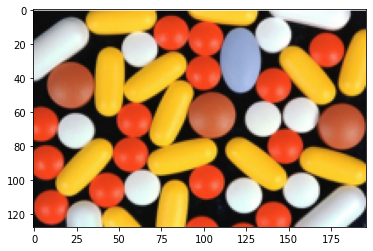

In [195]:
plt.imshow(pills)

In [46]:
pills3dpts = img2R3(pills, only_color=True, dist_weight=1)

In [47]:
centroids, labels = mean_shift(pills3dpts, radius=0.3, shift_stop_dist = 0.01, geometric_mean=True, mix_convergence=0.1)

Average shift distance: 0.0053326605010821015

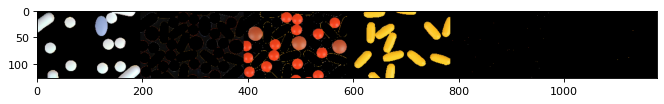

In [152]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(np.column_stack(regionimgs))

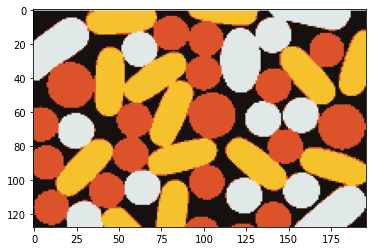

In [14]:
%matplotlib inline
quantized = get_region_quantized(pills, labels, centroids)
plt.imshow(quantized)

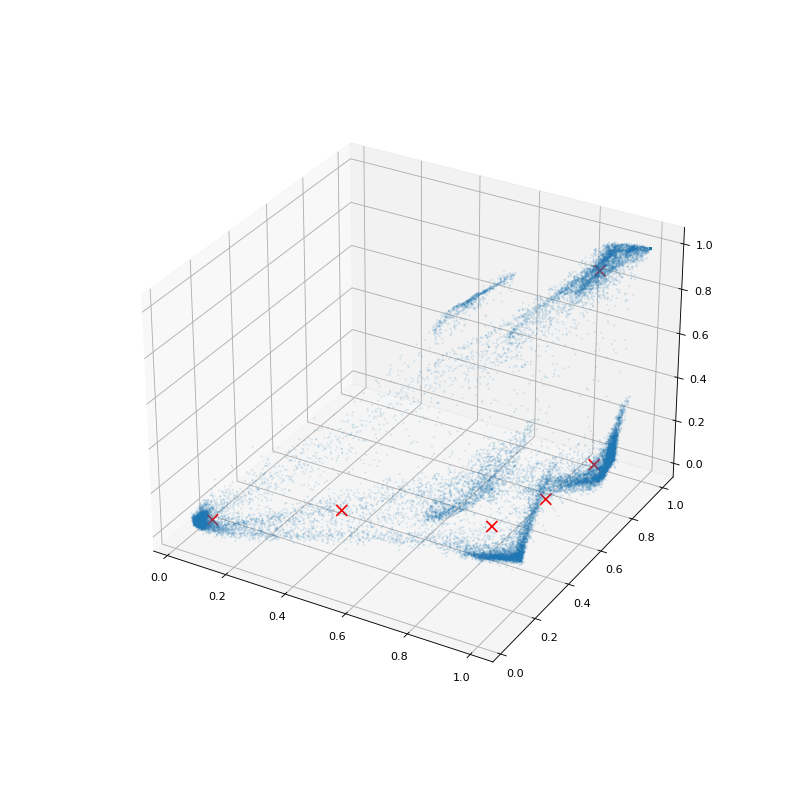

In [15]:
%matplotlib widget
fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(pills3dpts[:,0], pills3dpts[:,1],pills3dpts[:,2], alpha=0.1, s=1)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='x', color='red', s=100, alpha=1)

## Pills - Position Included

In [536]:
pills5d = img2R5(pills, dist_scale=2.95, color_scale=0.5)

In [537]:
centroids, labels = mean_shift(pills5d, radius=0.25, shift_stop_dist = 1e-4, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.0

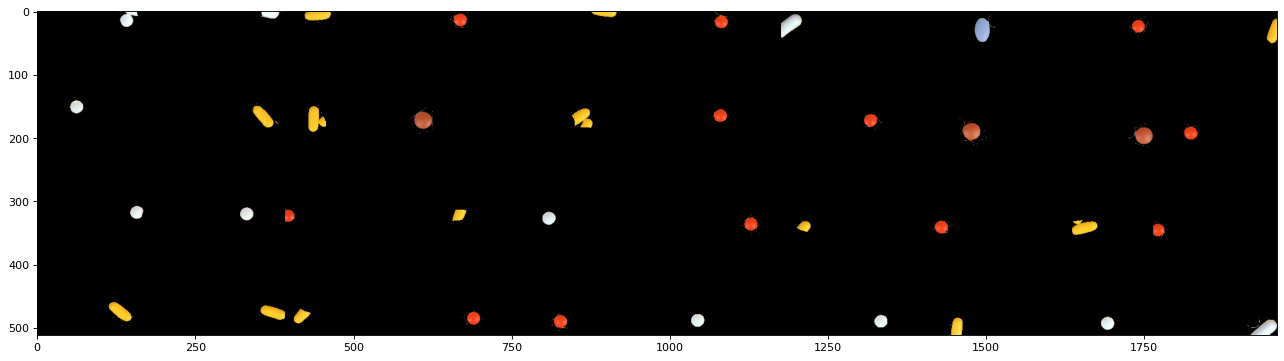

In [538]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
nonblackregions = [reg for reg in regionimgs if reg.mean() > 1]
plt.figure(num=None, figsize=(20, 20), dpi=80)
displayblock = np.row_stack([
    np.column_stack(nonblackregions[0:10]),
    np.column_stack(nonblackregions[10:20]),
    np.column_stack(nonblackregions[20:30]),
    np.column_stack(nonblackregions[30:40]),
    ]
)

plt.imshow(displayblock)

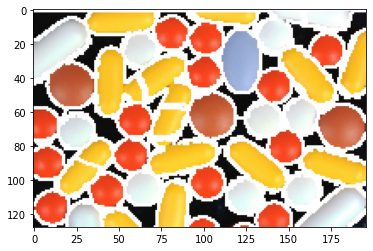

In [539]:
splitted = get_image_splitted(pills, labels, thickness=2)
plt.imshow(splitted)

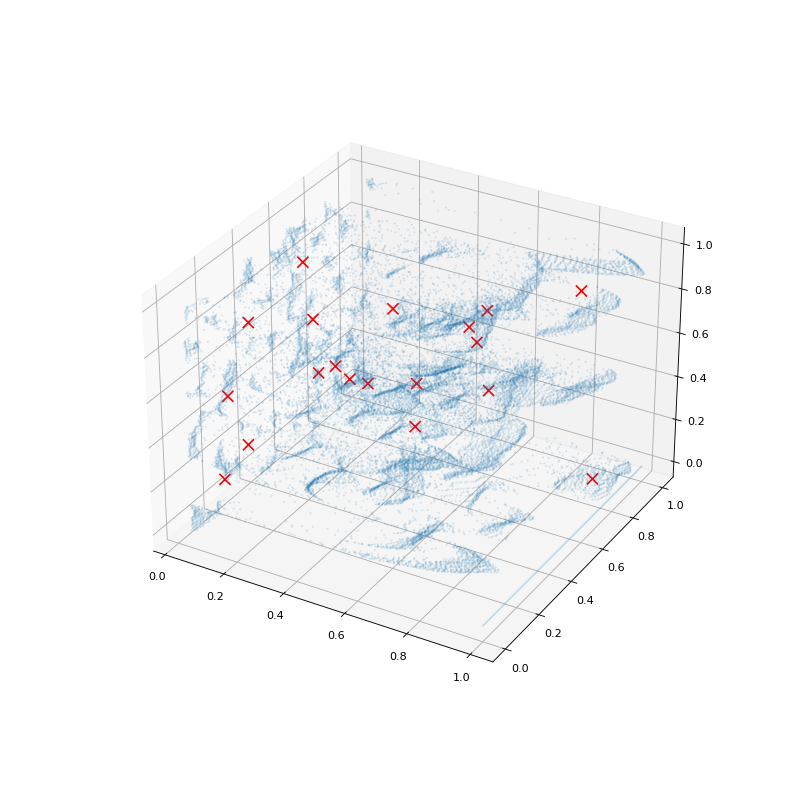

In [332]:
%matplotlib widget
fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(pills3dpos[:,0], pills3dpos[:,1],pills3dpos[:,2], alpha=0.1, s=1)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='x', color='red', s=100, alpha=1)

## Bird

In [1]:
smallbird = cv2.resize(bird, dsize=(100,100))
plt.imshow(smallbird)

NameError: name 'cv2' is not defined

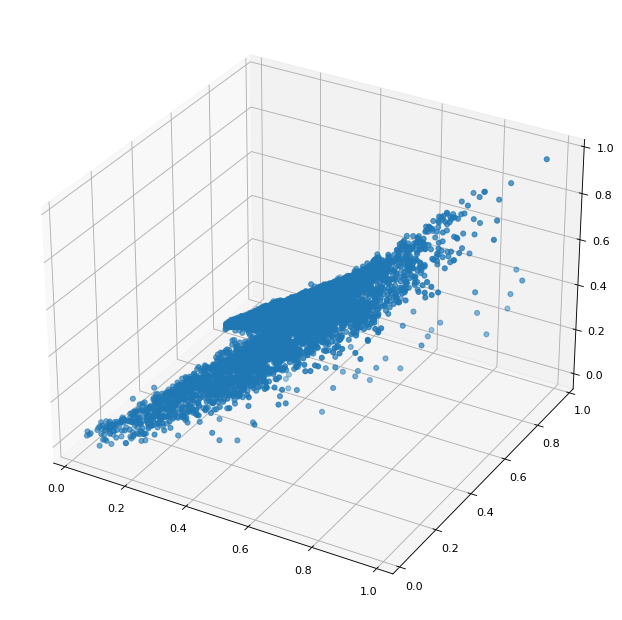

In [ ]:
bird3dpts = smallbird.reshape(-1, 3) / 255

fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(bird3dpts[:,0], bird3dpts[:,1],bird3dpts[:,2])

In [ ]:
labels = mean_shift(smallbird.reshape(-1, 3) / 255, radius=0.2, geometric_mean=True)

Average shift distance: 0.0009026031599195161

C:\Users\bizan\AppData\Local\Temp\ipykernel_20900\3642546413.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matlabels = np.array(labels).reshape(smallbird.shape[0], smallbird.shape[1])


ValueError: could not broadcast input array from shape (10000,3) into shape (10000,)

In [ ]:
_, labels = sk_mean_shift(smallbird.reshape(-1, 3) / 255)

sk_matlabels = np.array(labels).reshape(smallbird.shape[0], smallbird.shape[1])

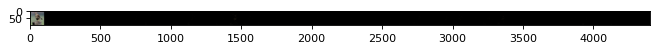

In [ ]:
display_region_split(smallbird, matlabels)

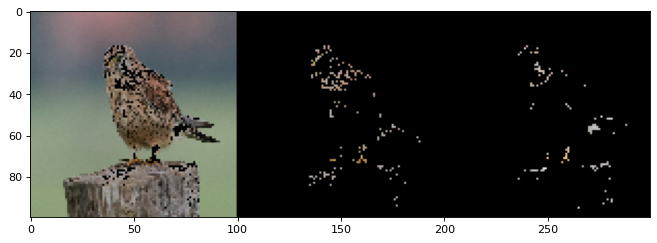

In [ ]:
display_region_split(smallbird, sk_matlabels)

## Super Pixels

In [ ]:
tinybird.reshape(-1,3)

array([[ 87, 100, 109],
       [ 84,  96, 104],
       [ 85,  97, 106],
       [ 82,  95, 103],
       [ 82,  97, 105],
       [ 86,  93,  94],
       [ 32,  30,  27],
       [148, 125, 111],
       [181, 165, 149],
       [165, 150, 135],
       [171, 158, 142],
       [125, 108,  93],
       [147, 137, 124],
       [ 94,  84,  77],
       [112, 100,  89],
       [186, 172, 156],
       [183, 168, 159],
       [169, 160, 151],
       [205, 190, 179],
       [183, 166, 158],
       [ 88, 101, 109],
       [ 82,  95, 103],
       [ 84,  97, 106],
       [ 82,  99, 107],
       [ 82,  96, 105],
       [114, 120, 120],
       [177, 168, 159],
       [150, 137, 121],
       [173, 161, 147],
       [148, 133, 114],
       [161, 148, 132],
       [149, 136, 120],
       [146, 133, 116],
       [123, 107,  91],
       [ 83,  69,  58],
       [ 77,  61,  46],
       [210, 189, 170],
       [187, 169, 159],
       [151, 131, 120],
       [183, 162, 145],
       [ 88, 103, 108],
       [ 84,  99

In [ ]:

print(tinybird)

[[[ 87 100 109]
  [ 84  96 104]
  [ 85  97 106]
  [ 82  95 103]
  [ 82  97 105]
  [ 86  93  94]
  [ 32  30  27]
  [148 125 111]
  [181 165 149]
  [165 150 135]
  [171 158 142]
  [125 108  93]
  [147 137 124]
  [ 94  84  77]
  [112 100  89]
  [186 172 156]
  [183 168 159]
  [169 160 151]
  [205 190 179]
  [183 166 158]]

 [[ 88 101 109]
  [ 82  95 103]
  [ 84  97 106]
  [ 82  99 107]
  [ 82  96 105]
  [114 120 120]
  [177 168 159]
  [150 137 121]
  [173 161 147]
  [148 133 114]
  [161 148 132]
  [149 136 120]
  [146 133 116]
  [123 107  91]
  [ 83  69  58]
  [ 77  61  46]
  [210 189 170]
  [187 169 159]
  [151 131 120]
  [183 162 145]]

 [[ 88 103 108]
  [ 84  99 106]
  [ 86 101 108]
  [ 86 101 108]
  [ 86 101 106]
  [ 83  98 101]
  [178 168 158]
  [150 135 114]
  [135 117  94]
  [159 142 122]
  [154 133 112]
  [164 146 126]
  [158 146 130]
  [167 148 130]
  [178 158 142]
  [134 116  96]
  [149 130 116]
  [133 109  89]
  [174 151 135]
  [194 161 142]]

 [[ 87 102 107]
  [ 89 103 107]
  

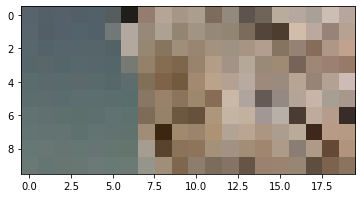

In [ ]:
tinybird = smallbird[30:40, 30:50]
plt.imshow(tinybird)

In [ ]:
tinybird.shape

(10, 20, 3)

In [ ]:
img2R3(tinybird).shape

(200, 3)

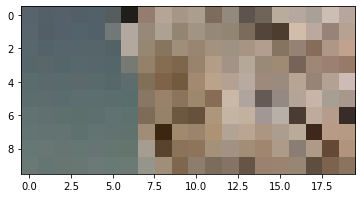

In [ ]:
plt.imshow(img2R3(tinybird, normalize=False).reshape(tinybird.shape[0], tinybird.shape[1], 3))

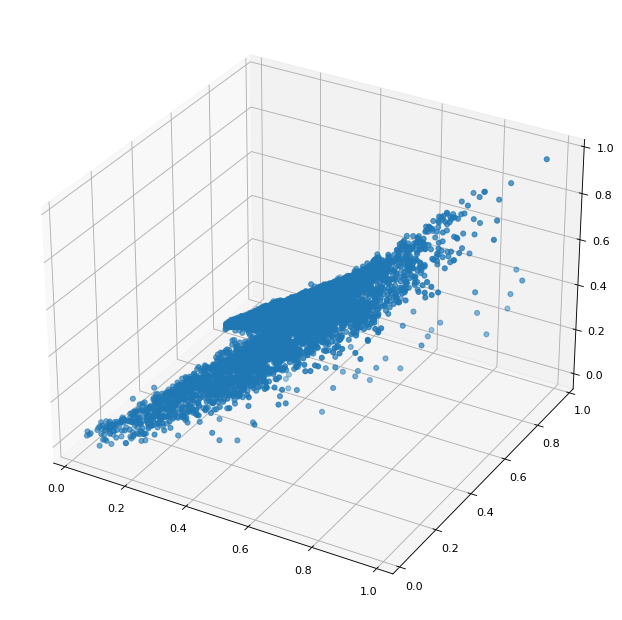

In [ ]:
bird3dpts = img2R3(smallbird)

fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(bird3dpts[:,0], bird3dpts[:,1],bird3dpts[:,2])

array([44, 30, 30, ..., 20, 20, 20])

In [ ]:
clusterer = KMeans(n_clusters=120, random_state=42)
clusterer.fit(img2R3(bird))





ValueError: cannot reshape array of size 607500 into shape (100,100)

dtype('uint8')

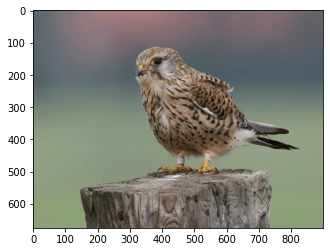

In [ ]:
coolimg = get_region_quantized(bird, clusterer.labels_.reshape(bird.shape[0], bird.shape[1]), clusterer.cluster_centers_)
plt.imshow(coolimg)